In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# init_mass_arr = np.arange(70, 151, 10)
# CO_mass_core_arr = np.full(init_mass_arr.shape, np.nan)
# for i, init_mass in enumerate(init_mass_arr):
#     datadir = Path('Over_00/%03d'%init_mass)
#     # chemistry
#     df_evolution_keyproperty = pd.DataFrame(columns=['model', 'COcore_mass'], dtype=(str, float))
#     for datapath in datadir.iterdir():
#         if datapath.suffix == '.chi':
#             model_name = datapath.stem
#             df = pd.read_table(datapath, sep='\s+', index_col=0)
#             df['COfrac'] = np.sum(df.loc[:, ['C12', 'C13', 'O15', 'O16', 'O17']], axis=1)
#             idx_COcore_edge = np.diff(df.loc[:, 'COfrac']).argmax()
#             M_mesh = np.diff(df.loc[1:idx_COcore_edge+1, 'M'].values)
#             COfrac_mesh = df.loc[1:idx_COcore_edge, 'COfrac'].values
#             COcore_mass = np.dot(M_mesh, COfrac_mesh)
#             df_evolution_keyproperty.loc[len(df_evolution_keyproperty)] = [model_name, COcore_mass]
#     df_evolution_keyproperty = df_evolution_keyproperty.sort_values('model', ignore_index=True)
#     idx_Cigni = df_evolution_keyproperty.loc[:, 'COcore_mass'].argmax()
#     if idx_Cigni == df_evolution_keyproperty.index.max():
#         continue
#     else:
#         CO_mass_core_arr[i] = df_evolution_keyproperty.loc[idx_Cigni, 'COcore_mass']

In [3]:
# overshoot = 0.0
# init_mass_arr = np.arange(70, 151, 10)
# CO_mass_core_arr = np.full(init_mass_arr.shape, np.nan)
# for i, init_mass in enumerate(init_mass_arr):
#     datadir = Path('Over_%02d/%03d'%(overshoot, init_mass))
#     # chemistry
#     df_evolution_keyproperty = pd.DataFrame(columns=['model', 'COcore_mass'], dtype=(str, float))
#     for datapath in datadir.iterdir():
#         if datapath.suffix == '.chi':
#             model_name = datapath.stem
#             df = pd.read_table(datapath, sep='\s+', index_col=0)
#             df['COfrac'] = np.sum(df.loc[:, ['He3', 'He4']], axis=1)
#             idx_COcore_edge = np.diff(df.loc[:, 'COfrac']).argmax()
#             M_mesh = np.diff(df.loc[1:idx_COcore_edge+1, 'M'].values)
#             COfrac_mesh = df.loc[1:idx_COcore_edge, 'COfrac'].values
#             COcore_mass = np.dot(M_mesh, COfrac_mesh)
#             df_evolution_keyproperty.loc[len(df_evolution_keyproperty)] = [model_name, COcore_mass]
#     df_evolution_keyproperty = df_evolution_keyproperty.sort_values('model', ignore_index=True)
#     idx_Cigni = df_evolution_keyproperty.loc[:, 'COcore_mass'].argmax()
#     # break
#     if idx_Cigni == df_evolution_keyproperty.index.max():
#         continue
#     else:
#         CO_mass_core_arr[i] = df_evolution_keyproperty.loc[idx_Cigni, 'COcore_mass']

In [4]:
# plt.scatter(init_mass_arr, CO_mass_core_arr, label=r'$\alpha_\mathrm{overshoot}=%.1f$'%overshoot)
# plt.ylabel(r'$\mathrm{CO\ Core\ Mass}\ M_\odot$')
# plt.xlabel(r'$\mathrm{Initial\ Mass}\ M_\odot$')
# plt.hlines([33, 54], xmin=65, xmax=155, linestyles='dashed', colors='r')
# # plt.ylim(19, 60)
# plt.legend()

In [5]:
# physical structure

In [13]:
# kippenhahn
overshoot = 0.0
init_mass_arr = np.arange(70, 151, 10)
CO_mass_core_arr = np.full(init_mass_arr.shape, np.nan)
for i, init_mass in enumerate(init_mass_arr[:1]):
    datadir = Path('/home/jiangrz/hdd23/INAC24G3/Over_%02d_finer/%03d'%(overshoot, init_mass))
    model_info = pd.DataFrame(columns=['name', 'age'], dtype=float)
    model_names = []
    for _path in datadir.iterdir():
        if (_path.suffix == '.atm'):
            model_names.append(_path.stem)
    # fort54 = pd.read_csv(datadir/'fort.54', delimiter='\s+', header=None)
    model_names.sort()
    model_info['name'] = model_names
    y_gridnum = 2500
    y_grid = np.linspace(0, init_mass, y_gridnum)
    y_mesh = np.diff(y_grid)/2+y_grid[:-1]
    E_arr = np.full((len(model_info), len(y_mesh)), np.nan)
    RADDAD_arr = np.full((len(model_info), len(y_mesh)), np.nan)
    for row_idx, row in model_info.iterrows():
        model_name = row['name']
        df_f01 = pd.read_csv(
            datadir/('%s.f01'%model_name), delimiter='\s+', 
            usecols=[1, 6, 18]).reset_index(drop=True)
        df_f01.loc[len(df_f01)+1] = np.full(3, np.nan)
        df_chi = pd.read_csv(
            datadir/('%s.chi'%model_name), delimiter='\s+', 
            usecols=[1])
        df_qva = pd.read_csv(
            datadir/('%s.qva'%model_name), delimiter='\s+', 
        )
        age = df_qva.loc[0, 'AGE']
        model_info.loc[row_idx, 'age'] = age
        E_arr[row_idx, :len(df_f01)] = df_f01['M/MTOT'].values
        RADDAD_arr[row_idx, :len(df_f01)] = np.sign(df_f01['RAD-DAD'])
        # RADDAD_arr[RADDAD_arr < 1] = np.nan
        adopt_idx = np.sum((y_mesh >= df_chi['M'].values.reshape(-1, 1)), axis=0)-1
        adopt_E = df_f01['E-TOT'].values[adopt_idx]
        E_arr[row_idx, :] = adopt_E
    model_info['logt'] = np.log10(model_info['age'].values[-1]-model_info['age'].values+0.5)
    x_mesh = model_info['logt'].values
    mgrid = np.meshgrid(x_mesh, y_mesh)
    
    # mass_mesh = datadir
    # df_keyproperty = pd.DataFrame(columns=['model', 'time', ], dtype=(str, float))
    

In [14]:
x_meshdiff = np.diff(x_mesh)
x_grid = np.concatenate(([x_mesh[0]-x_meshdiff[0]/2], x_meshdiff/2+x_mesh[:-1], [x_mesh[-1]+x_meshdiff[-1]/2]))
signlogE_arr = np.sign(E_arr.T)*np.log10(np.abs(E_arr.T))

/tmp/ipykernel_3995584/3702467238.py:7: UserWarning: The following kwargs were not used by contour: 'level'
  shade = plt.contourf(
/tmp/ipykernel_3995584/3702467238.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(c, label=r'$\mathrm{sign}(E)\cdot\log E$')


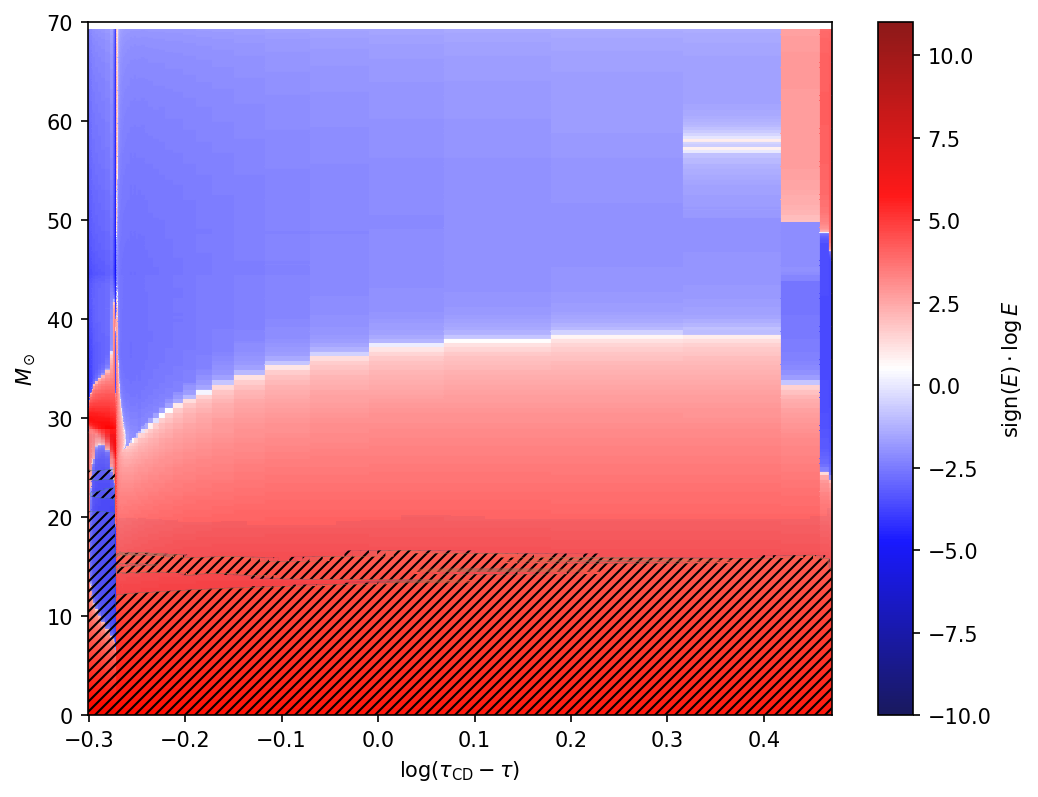

In [15]:
plt.figure(figsize=(8, 6), dpi=150)
X, Y = np.meshgrid(x_grid, y_grid)
vmin = np.floor(np.nanmin(signlogE_arr))
vmax = np.ceil(np.nanmax(signlogE_arr))
c = plt.pcolor(X, Y, signlogE_arr, cmap='seismic', vmin=vmin, vmax=vmax, alpha=.9, edgecolors='none')
# shade = plt.pcolor(X, Y, RADDAD_arr.T, cmap='binary', vmin=-1, vmax=1, alpha=.05, edgecolors='face')
shade = plt.contourf(
    x_mesh, y_mesh, RADDAD_arr.T, 
    hatches=[None, '/////'], level=3, alpha=.05)
plt.colorbar(c, label=r'$\mathrm{sign}(E)\cdot\log E$')
plt.ylabel(r'$M_\odot$');
plt.xlabel(r'$\log(\tau_\mathrm{CD}-\tau)$');
# plt.xlim(-2, -1)
# plt.colorbar()

/tmp/ipykernel_3981591/2426682333.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(c, label=r'$\mathrm{sign}(E)\cdot\log E$')


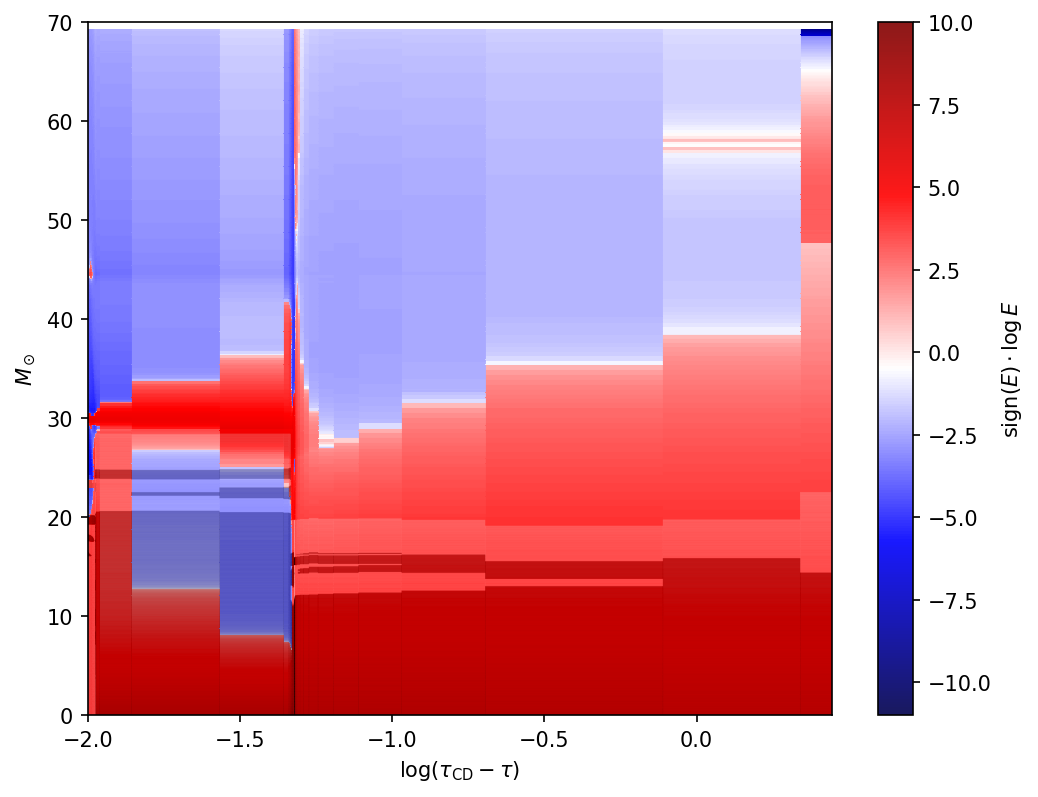

In [41]:
plt.figure(figsize=(8, 6), dpi=150)
X, Y = np.meshgrid(x_grid, y_grid)
vmin = np.floor(np.nanmin(signlogE_arr))
vmax = np.ceil(np.nanmax(signlogE_arr))
c = plt.pcolor(X, Y, signlogE_arr, cmap='seismic', vmin=vmin, vmax=vmax, alpha=.9, edgecolors='none')
shade = plt.pcolor(X, Y, RADDAD_arr.T, cmap='binary', vmin=-1, vmax=1, alpha=.05, edgecolors='face')
# shade = plt.pcolor(
#     X, Y, RADDAD_arr.T, cmap=
#     vmin=vmin, vmax=vmax, level=3, alpha=.05, edgecolors='face')
plt.colorbar(c, label=r'$\mathrm{sign}(E)\cdot\log E$')
plt.ylabel(r'$M_\odot$');
plt.xlabel(r'$\log(\tau_\mathrm{CD}-\tau)$');
# plt.colorbar()